# Heaving amplitude analysis

Changes in cross-slope heat transport could be due to heaving isopycnals. One way tot est that is to measure the variability of the depth of a particular isopycnal and see if that variaiblity matches the CSHT one. we will test that here

In [1]:
# Load necessary modules
import intake
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm
from xhistogram.xarray import histogram
import warnings
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
import dask.config
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [3]:
client = Client(threads_per_worker = 1)

In [4]:
catalog = intake.cat.access_nri
ylength=580

In [5]:
#in this definition, no frequency can be used only for static data
def importer(experiment,catalog,variable, frequency = 'fx',start_time=0,end_time=0):
    warnings.filterwarnings('ignore')
    if experiment== "panant-01-zstar-ACCESSyr2":
        var = catalog[experiment].search(variable=variable, frequency = frequency).to_dask(xarray_open_kwargs={'decode_timedelta':True})
    else: 
        #other resolutions have the same variable with z_l and z_l_sub z dim in different times.
        # I will filter to the time I want knowing th their specificities
        #IOW this fix works just for the models and variables used in this notebook
        if variable=='uo' or variable=='vo':
            var = catalog[experiment].search(variable=variable, frequency = frequency)
            keysnames = var.keys() ; search_term = "z_l_sub01"
            matches = [s for s in keysnames if search_term in s]
            var = catalog[experiment].search(variable=variable, frequency = frequency,file_id = matches).to_dask(xarray_open_kwargs={'decode_timedelta':True})
        else:
            var = catalog[experiment].search(variable=variable, frequency = frequency).to_dask(xarray_open_kwargs={'decode_timedelta':True})
    
    if start_time!=0:
        time_slice='slice(start_time,end_time)'
        return eval("var." + variable + ".sel(time=" + time_slice + ")")
    elif start_time ==0:
        return eval("var." + variable)

In [6]:
#importing CSHT along for reference
#lighter CSHT matrix to make easier to find TS along isobath
CSHT_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/WMbins_daily_rho/*')
CSHT_along = CSHT_along.isel(time=0).drop('time')
#importing monthly potrho0 along contour
pot_rho0_along_contour = xr.open_dataset('/g/data/x77/wf4500/ASC_project/Post_process/rho0_along_contour.nc')
#importing 3 degrees binned u_along for reference too
#importing the daily ualong in z coords, 3deg binned 
u_along_binned_z = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/ASC_speed/daily_z_3deg/along_slope/*')

In [7]:
#area
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'
area = importer(iaf_cycle3,catalog,'area_t').isel(yt_ocean=slice(0,ylength))
area_transect = area.sel(xt_ocean = CSHT_along.lon_along_contour,yt_ocean=CSHT_along.lat_along_contour,method='nearest')
area_transect.load()
print('Loaded area along the isobath')

Loaded area along the isobath


first we need to bin these densities in 10 degree bins

In [8]:
def binning_density_3deg(pot_rho0_along_contour, area_transect,u_along_binned_z):
    
    #binning into 3deg
    bin_width = 3
    bin_spacing = 0.25
    lon_west = -280
    lon_east = 80
    
    # new coordinate and midpoints of longitude bins:
    full_lon_coord = np.arange(lon_west,lon_east+bin_spacing,bin_spacing)
    lon_bin_midpoints = np.arange(lon_west+bin_width/2,lon_east-bin_width/2,bin_spacing)
    
    n_bin_edges = len(full_lon_coord)
    lon_along_contour = np.array(CSHT_along.lon_along_contour)
    lat_along_contour = np.array(CSHT_along.lat_along_contour)
    
    
    bin_edge_indices = np.zeros(n_bin_edges)
    for lon_bin in range(n_bin_edges-1):
        # find first isobath point that has the right longitude:
        first_point = np.where(lon_along_contour>=full_lon_coord[lon_bin])[0][0]
        # then find all other isobath points with the same longitude as that first point:
        same_lon_points = np.where(lon_along_contour==lon_along_contour[first_point])[0]
        # we want the most southerly of these points on the same longitude line:
        bin_edge_indices[lon_bin] = same_lon_points[np.argmin(lat_along_contour[same_lon_points])]
        
    # define east/west edges:
    bin_edge_indices = bin_edge_indices.astype(int)
    bin_edge_indices_west = bin_edge_indices[:-int(bin_width/bin_spacing)-1]
    bin_edge_indices_east = bin_edge_indices[int(bin_width/bin_spacing):-1]
    n_bins = len(bin_edge_indices_west)
    
    
    lat_bin_midpoints = np.zeros(n_bins)
    for lon_bin in range(n_bins):
        # find nearest isobath point:
        lon_index = np.where(lon_along_contour>=lon_bin_midpoints[lon_bin])[0][0]
        lat_bin_midpoints[lon_bin] = lat_along_contour[lon_index]
    
    
    area_contour_3deg = np.zeros(u_along_binned_z.isel(time=0).u_along_contour_binned.shape[1])*np.nan
    for lon_bin in range(n_bins):
        area_contour_3deg0 = area_transect[bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
        area_contour_3deg[lon_bin] = (np.nansum(area_contour_3deg0))
    del area_contour_3deg0
    
    #removing zeros
    area_contour_3degnp = np.where(area_contour_3deg!=0,area_contour_3deg,np.nan)
    
    #areas_3deg
    area_contour_3deg = u_along_binned_z.u_along_contour_binned.isel(time=0,st_ocean=0).copy()
    area_contour_3deg.name = 'Area'
    area_contour_3deg.values = area_contour_3degnp
    
    #binning potrho0
    refxr = u_along_binned_z.u_along_contour_binned.resample(time='1M').mean()
    pot_rho0_3deg = np.zeros(refxr.shape)*np.nan
    for lon_bin in range(n_bins):
        area_contour_3deg0 = area_transect[bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]] #for weighting
        pot_rho0_3deg0 = pot_rho0_along_contour.pot_rho_0[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
        pot_rho0_3deg0_Nans = (1 +pot_rho0_3deg0*0)
        pot_rho0_3deg[:,:,lon_bin] = (np.nansum(pot_rho0_3deg0*area_contour_3deg0,axis=2))/(np.nansum(area_contour_3deg0*pot_rho0_3deg0_Nans,axis=0))

    #removing zeros
    pot_rho0_3degnp = np.where(pot_rho0_3deg!=0,pot_rho0_3deg,np.nan)
    
    #areas_3deg
    pot_rho0_3deg = refxr.copy()
    pot_rho0_3deg.name = 'pot_rho0'
    pot_rho0_3deg.values = pot_rho0_3degnp

    
    return pot_rho0_3deg, area_contour_3deg

In [9]:
%%time
pot_rho0_3deg, area_contour_3deg = binning_density_3deg(pot_rho0_along_contour, area_transect,u_along_binned_z)

CPU times: user 3min 11s, sys: 5min 49s, total: 9min
Wall time: 6min 15s


Text(0.5, 0, '$\\sigma_0$')

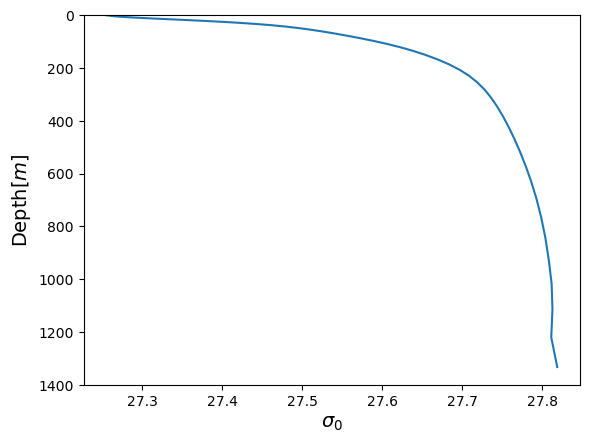

In [10]:
# sanity test
(pot_rho0_3deg.mean(('time','lon_bin_midpoints')) - 1000).plot(y='st_ocean')
plt.ylim(1400,0)
plt.ylabel(r'Depth[$m$]',fontsize=14)
plt.xlabel(r'$\sigma_0$',fontsize=14)

# Binning density in 10 degree bins

In [11]:
# #first, creating the Z mask so we make sure we get the right sigmas in the right locations
CSHTZC_z = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_z/*')

In [12]:
lon_bin=10
bin_edges = np.arange(CSHTZC_z.lon_bin_midpoints[0], CSHTZC_z.lon_bin_midpoints[-1]+(lon_bin/2), lon_bin)
lon_bin_mid = np.arange((bin_edges[0]+(lon_bin/2)),(bin_edges[-1]+(lon_bin/2)),lon_bin) # for 10-deg bins
newlon = np.concatenate((CSHTZC_z.lon_bin_midpoints.values,np.arange(78.5,81.5,.25)), axis=0)
longfix = xr.DataArray(newlon, coords={'lon_bin_midpoints': newlon},dims=['lon_bin_midpoints'])
meantime = CSHTZC_z.time.resample(time='1M').mean()

#binning area into 10 degree bins
area_contour_3deg_halo = xr.concat([area_contour_3deg,area_contour_3deg.isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')
area_contour_3deg_halo['lon_bin_midpoints'] = longfix
area_10deg_binned = area_contour_3deg_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints')
#binning density
pot_rho0_3deg_halo = xr.concat([pot_rho0_3deg,pot_rho0_3deg.isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')
pot_rho0_3deg_halo['lon_bin_midpoints'] = longfix
pot_rho0_3deg_halo_mask = (1 + pot_rho0_3deg_halo*0)
area_contour_3deg_halo_denominator = area_contour_3deg_halo * pot_rho0_3deg_halo_mask 
pot_rho0_3deg_halo = pot_rho0_3deg_halo* area_contour_3deg_halo #contour density multiplied by the volume in z coordinates


pot_rho0_10deg_binned = pot_rho0_3deg_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints') /\
area_contour_3deg_halo_denominator.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints')

pot_rho0_10deg_binned = pot_rho0_10deg_binned.rename({'lon_bin_midpoints_bins':'lon_bins'})
pot_rho0_10deg_binned['lon_bins'] = lon_bin_mid
pot_rho0_10deg_binned.name='pot_rho0'

Text(0.5, 0, '$\\sigma_0$')

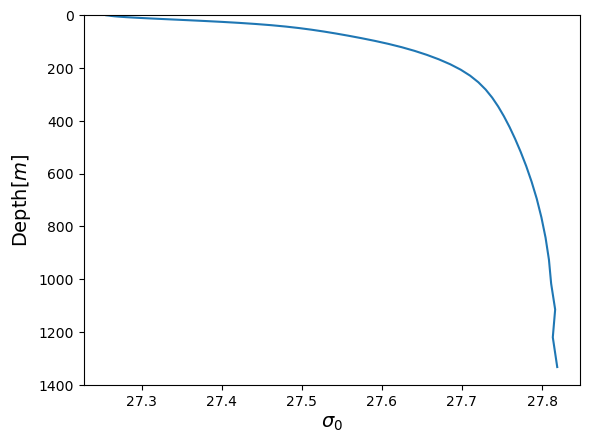

In [13]:
#sanity check 2
(pot_rho0_10deg_binned.mean(('time','lon_bins')) - 1000).plot(y='st_ocean')
plt.ylim(1400,0)
plt.ylabel(r'Depth[$m$]',fontsize=14)
plt.xlabel(r'$\sigma_0$',fontsize=14)

In [14]:
# #saving 10-degree binned densities
# savedir_rho = '/g/data/x77/wf4500/ASC_project/potrho0_monthly_z/'
# pot_rho0_10deg_binned.to_netcdf(savedir_rho + 'potrho0_10deg_z_IAF.nc')

In [15]:
#calcualting annual mean
pot_rho0_10deg_binned_yearly = pot_rho0_10deg_binned.resample(time='1Y').mean()
# pot_rho0_10deg_binned_yearly.to_netcdf(savedir_rho + 'yearly_potrho0_10deg_z_IAF.nc')

Let's find the desired density level. This level has to be the max(z),min(time) of an existing density, so we know this density layer always exist

In [16]:
#defining the annual and monthly densities we will track
annual_tracking_density = pot_rho0_10deg_binned_yearly.min('time').max('st_ocean')
monthly_tracking_density = pot_rho0_10deg_binned.min('time').max('st_ocean')

For our measurement of heaving to not depend so much of the thickness of $z^*$ cells, we will first interpoalted the values in thin enough depth layers

In [17]:
%%time
#depth will be separated into 10 meters layers
Zinterp = np.arange(pot_rho0_10deg_binned_yearly.st_ocean[0],pot_rho0_10deg_binned_yearly.st_ocean[-1],10)
#interpoalting annual density
pot_rho0_10deg_binned_yearly_Zinterp = pot_rho0_10deg_binned_yearly.interp(st_ocean = Zinterp,method='linear')
pot_rho0_10deg_binned_Zinterp = pot_rho0_10deg_binned.interp(st_ocean = Zinterp,method='linear')

CPU times: user 206 ms, sys: 165 ms, total: 371 ms
Wall time: 242 ms


Text(0.5, 0, '$\\sigma_0$')

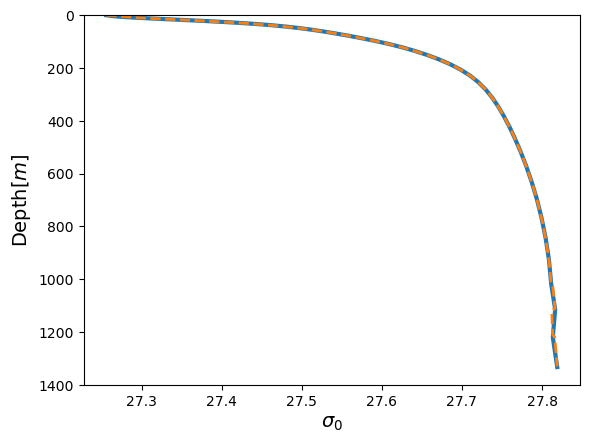

In [18]:
#checking if they match  with non-interpolated densities
#sanity check 2
(pot_rho0_10deg_binned.mean(('time','lon_bins')) - 1000).plot(y='st_ocean',lw=3,label = 'non-interpolated')
(pot_rho0_10deg_binned_yearly_Zinterp.mean(('time','lon_bins')) - 1000).plot(y='st_ocean',lw=2,linestyle='--',label='interpolated')
plt.ylim(1400,0)
plt.ylabel(r'Depth[$m$]',fontsize=14)
plt.xlabel(r'$\sigma_0$',fontsize=14)


Looks reasonable

In [19]:
%%time
#tracking annual heaving
annual_density_depth = pot_rho0_10deg_binned_yearly_Zinterp.isel(st_ocean=0).copy()
annual_density_depth.name = 'AnnualCDWdepth'
for n in range(pot_rho0_10deg_binned_yearly_Zinterp.lon_bins.count().values):
    for t in range(pot_rho0_10deg_binned_yearly_Zinterp.time.count().values):
        tracking_annual0  = pot_rho0_10deg_binned_yearly_Zinterp.isel(lon_bins=n).isel(time=t)
        closest_index = (((tracking_annual0 - (annual_tracking_density.isel(lon_bins=n)))**2)**0.5).argmin('st_ocean')
        closest_value = pot_rho0_10deg_binned_yearly_Zinterp.st_ocean.isel(st_ocean=int(closest_index))
        annual_density_depth[t,n] = closest_value.values

CPU times: user 2.98 s, sys: 63.7 ms, total: 3.04 s
Wall time: 2.98 s


In [20]:
%%time
#tracking monthly heaving
monthly_density_depth = pot_rho0_10deg_binned_Zinterp.isel(st_ocean=0).copy()
monthly_density_depth.name = 'monthlyCDWdepth'
for n in range(pot_rho0_10deg_binned_Zinterp.lon_bins.count().values):
    for t in range(pot_rho0_10deg_binned_Zinterp.time.count().values):
        tracking_monthly0  = pot_rho0_10deg_binned_Zinterp.isel(lon_bins=n).isel(time=t)
        closest_index = (((tracking_monthly0 - (monthly_tracking_density.isel(lon_bins=n)))**2)**0.5).argmin('st_ocean')
        closest_value = pot_rho0_10deg_binned_Zinterp.st_ocean.isel(st_ocean=int(closest_index))
        monthly_density_depth[t,n] = closest_value.values

CPU times: user 36.6 s, sys: 989 ms, total: 37.6 s
Wall time: 36.7 s


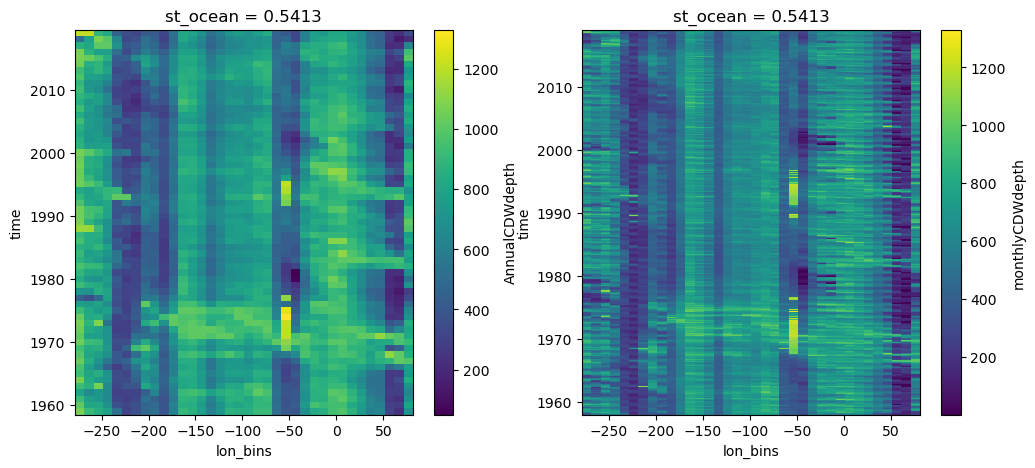

In [21]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
annual_density_depth.plot()
plt.subplot(1,2,2)
monthly_density_depth .plot()

How does the standard deviation of depth happen among those? do the reagions with large "heaving", line up with locations of strong correlations?

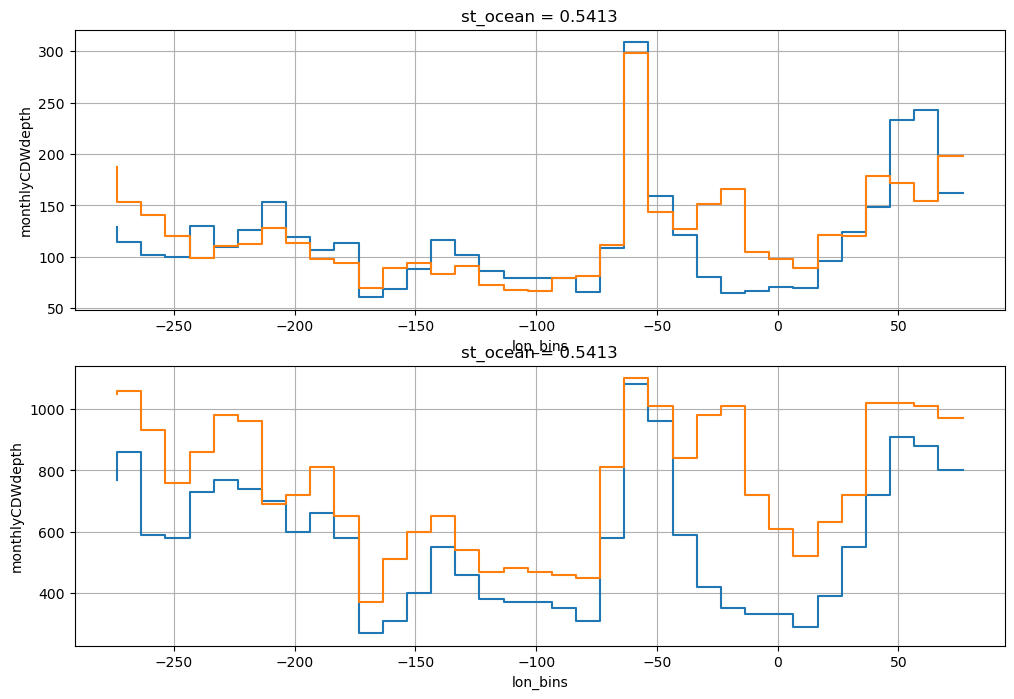

In [22]:
plt.figure(figsize=(12,8))

plt.subplot(2,1,1)
annual_density_depth.std('time').plot.step(label = 'Annual SD')
monthly_density_depth.std('time').plot.step(label = 'Monthly SD')
plt.grid()
plt.subplot(2,1,2)
(annual_density_depth.max('time') - annual_density_depth.min('time') ).plot.step(label = 'Annual range')
(monthly_density_depth.max('time') - monthly_density_depth.min('time')).plot.step(label = 'Monthly range')
plt.grid()

## Correlation CSHT with isopycnal depth

First, lets interpoalte the monthly data into daily

In [23]:
%%time
#creating source and target dates for interpolation
time_tointerp = CSHTZC_z.time.sel(time=slice('1959-01-01','1959-12-31'))
time_monthly = CSHTZC_z.time.sel(time=slice('1958-12-01','1960-01-31')).resample(time='1M').mean()
#interpolating
monthly_climatology_density_depth = monthly_density_depth.groupby('time.month').mean()
monthly_climatology_density_depth = xr.concat([monthly_climatology_density_depth.isel(month=11),monthly_climatology_density_depth,\
                                               monthly_climatology_density_depth.isel(month=0),], dim='month').rename({'month':'time'})
monthly_climatology_density_depth['time'] = time_monthly 
daily_climatology_density_depth = monthly_climatology_density_depth.interp(time=time_tointerp).groupby('time.dayofyear').mean()

CPU times: user 23 ms, sys: 5.16 ms, total: 28.1 ms
Wall time: 25.7 ms


In [24]:
#improting masks
# Daily age mask
age_mask_daily = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/age_mask_daily/OM2_01_iaf_cycle3/*.nc')
# monthly water mass mask 
age_mask_monthly = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/**_age_mask.nc')

In [25]:
#importing CSHT in density bins
CSHT_along = xr.open_mfdataset('/g/data/e14/fbd581/ASC_project/Lon_binning/CSHT_ZC_potrho0_10degBins.nc',\
                               chunks = {'time' : 100,'lon_bins':12})

In [26]:
age_mask = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/**_age_mask.nc')

In [27]:
#annual mean CSHT from CDW
CSHT_CDW_annual = (CSHT_along.CSHT_ZC_lon_binned.resample(time='1M').mean() *age_mask.CDW_mask).sum('potrho0').resample(time='1Y').mean().compute()
CSHT_CDW_daily = (CSHT_along.CSHT_ZC_lon_binned * age_mask_daily.CDW_mask).sum('potrho0').groupby('time.dayofyear').mean().isel(dayofyear=slice(0,365)).compute()

Calculating correlations

In [28]:
#calculating monthly layerwise correlation
annual_layerwise_correlations_ρ = xr.corr(CSHT_CDW_annual,\
                                           annual_density_depth,dim = 'time').compute()
annual_layerwise_correlations_r2s_ρ = (xr.corr(CSHT_CDW_annual,\
                                           annual_density_depth,dim = 'time')**2).compute()



# daily correlations
daily_layerwise_correlations_ρ = xr.corr(CSHT_CDW_daily,\
                                           daily_climatology_density_depth,dim = 'dayofyear').compute()
daily_layerwise_correlations_r2s_ρ = (xr.corr(CSHT_CDW_daily,\
                                           daily_climatology_density_depth,dim = 'dayofyear')**2).compute()

In [29]:
longitude_inds = np.array([5,36-15, 14, 3,10,17,36-12,36-10, 36-1,1])
regions_abridged = ['Mertz','WAP', 'Getz', 'Totten',\
           'Glomar', 'Amundsen', 'Filchner', \
           'Riiser-Larsen', 'Amery', 'Denman']

Text(0.5, 0, 'Longitude')

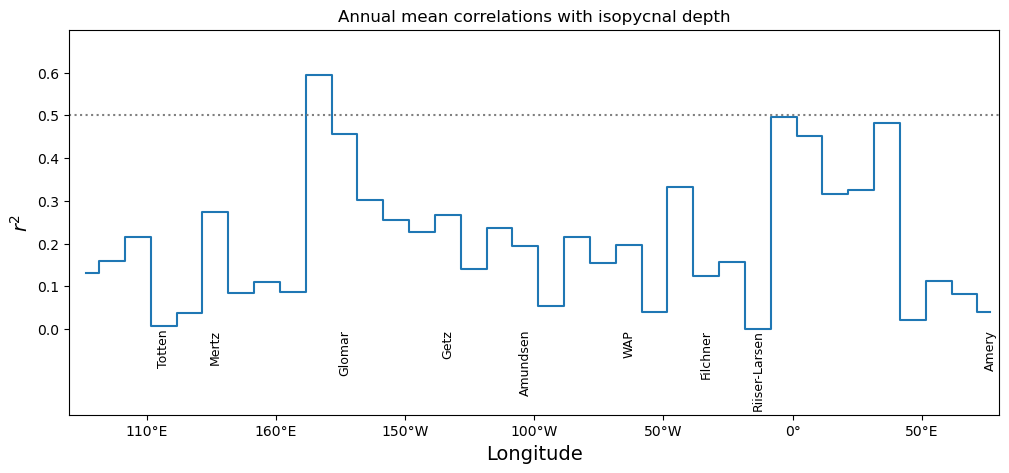

In [30]:
fig = plt.figure(figsize=(12,5))

ax0 = fig.add_subplot(1,1,1)
annual_layerwise_correlations_r2s_ρ.plot.step(label = r'$r^2_{annual}$', where='mid')
plt.plot([-280,80],[0.5,0.5],color='grey',linestyle=':')
plt.title('Annual mean correlations with isopycnal depth')
plt.ylabel(r'$r^2$',fontsize = 14)
for i in range(9):
    plt.text(annual_layerwise_correlations_r2s_ρ.lon_bins[longitude_inds[i]], 0, regions_abridged[i], rotation=90,fontsize=9, va='top', ha='center',color='black')
plt.xlim(-280,80)
plt.ylim(-.2,.7)
plt.yticks(ticks=[0,0.1,.2,.3,.4,.5,.6])
ax0.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel('Longitude',fontsize = 14)

Text(0.5, 0, 'Longitude')

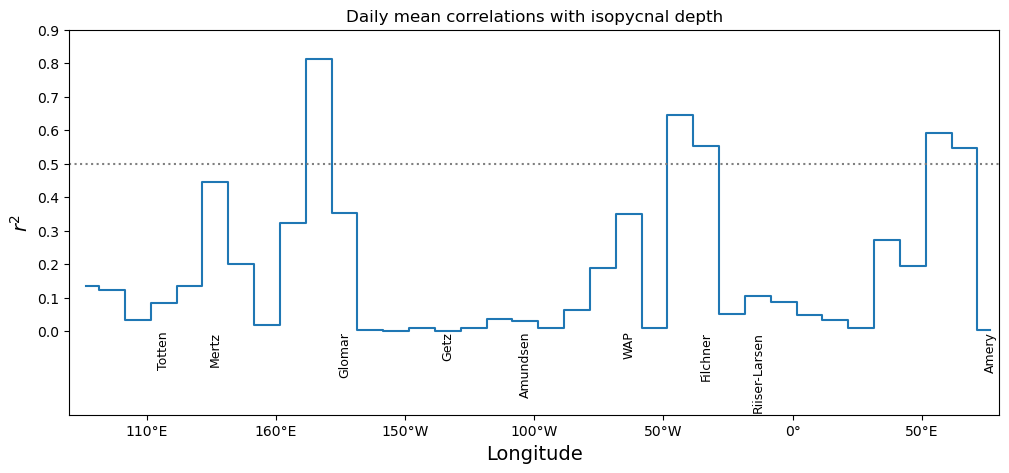

In [31]:
fig = plt.figure(figsize=(12,5))

ax0 = fig.add_subplot(1,1,1)
daily_layerwise_correlations_r2s_ρ.plot.step(label = r'$r^2_{daily}$', where='mid')
plt.plot([-280,80],[0.5,0.5],color='grey',linestyle=':')
plt.title('Daily mean correlations with isopycnal depth')
plt.ylabel(r'$r^2$',fontsize = 14)
for i in range(9):
    plt.text(annual_layerwise_correlations_r2s_ρ.lon_bins[longitude_inds[i]], 0, regions_abridged[i], rotation=90,fontsize=9, va='top', ha='center',color='black')
plt.xlim(-280,80)
plt.ylim(-.25,.9)
plt.yticks(ticks=[0,0.1,.2,.3,.4,.5,.6,.7,.8,.9])
ax0.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel('Longitude',fontsize = 14)

## Correlations with EKE

Perhaps the CSHT from CDW do not have that much correlation with ASC speed, but it could have a correlation with EKE somewhere in the water column. Let's calculate EKE along the contour and correlate with the CSHT too

In [37]:
#importing cross-slope velocities, which will be required to calcualte EKE - 3deg bins
v_cross_binned_z = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/ASC_speed/daily_z_3deg/cross_slope/*')

In [46]:
#10 deg binned along slope and cross slope velocities
v_cross_10deg = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/ASC_cross_z_daily_10deg/OM2_01_iaf_cycle3/*')
u_along_10deg = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/ASC_z_daily_10deg/OM2_01_iaf_cycle3/*')


In [38]:
from random import randint as randint

(1200.0, 0.0)

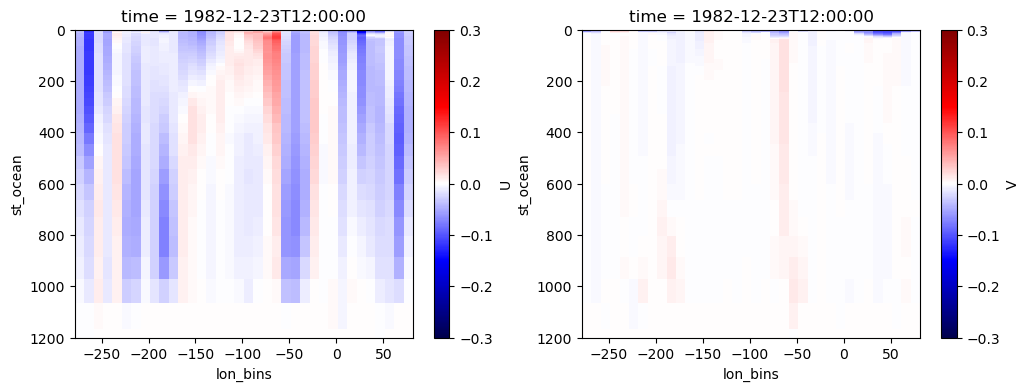

In [55]:
#sanity check using randomly selected time means
Tind = randint(0,v_cross_10deg.time.count().values)
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
u_along_10deg.U.isel(time=Tind).plot(vmin=-.3,vmax=.3,cmap='seismic')
plt.ylim(1200,0)

plt.subplot(1,2,2)
v_cross_10deg.V.isel(time=Tind).plot(vmin=-.3,vmax=.3,cmap='seismic')
plt.ylim(1200,0)

They seem reasonably different to me

Next, to do correlations between the EKE and the CSHT from CDW, we need to make sure the EKE is calculated respecting the timescales we averaged the CSHT. So let's do it separately

### Annual means of EKE

For this one, we will calculate the long-term annual mean of $U$  ($\bar{U}_{annual}$) and $V$ ($\bar{V}_{annual}$). Our EKE will be calculated using the anomalies from that mean,. i.e.,

$$
U'_{annual} = U - \bar{U}_{annual}
$$

$$
V'_{annual} = V - \bar{V}_{annual}
$$

Which will lead EKE to be

$$
EKE_{annual} = 0.5 \times (U' \ ^{2}_{annual} \ + \ V' \ ^{2}_{annual} )
$$

In [72]:
# calculating annual means
u_along_10deg_annualmean = u_along_10deg.U.resample(time='1Y').mean().mean('time').compute()
v_cross_10deg_annualmean = v_cross_10deg.V.resample(time='1Y').mean().mean('time').compute()

In [73]:
#calculating U' and V'
U_prime_annual = u_along_10deg.U.resample(time='1Y').mean() - u_along_10deg_annualmean 
V_prime_annual = v_cross_10deg.V.resample(time='1Y').mean() - v_cross_10deg_annualmean

In [77]:
# Calculating Annual EKE 
EKE_annual = (0.5 * ((U_prime_annual**2) + (V_prime_annual**2)) ).compute()

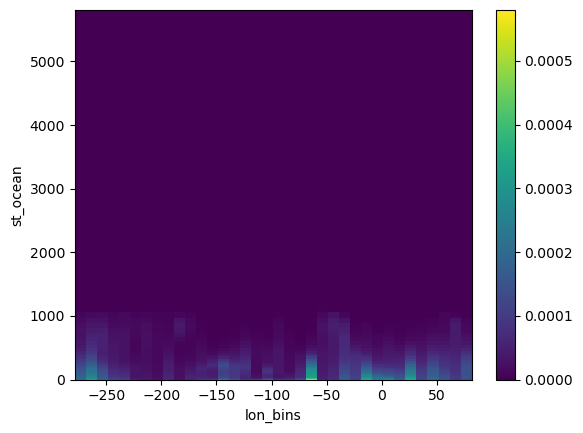

In [78]:
# visual check
EKE_annual.mean('time').plot()

### Daily climatological mean of EKE

This on is a bit trickier because we need a mean, but want to maintain the seasonal cycle. for that, we will use the long term daily mean
For this one, we will calculate the long-term daily mean of $U$  ($\bar{U}_{daily}$) and $V$ ($\bar{V}_{daily}$). We will also calcualte the daily climatology of  $U$ ($\bar{U}_{clim}$) and $V$ ($\bar{V}_{clim}$).           Our EKE will be calculated using the anomalies from that mean,. i.e.,

$$
U'_{daily} = \bar{U}_{clim} - \bar{U}_{daily}
$$

$$
V'_{daily} = \bar{V}_{clim} - \bar{V}_{daily}
$$

Which will lead EKE to be

$$
EKE_{daily} = 0.5 \times (U' \ ^{2}_{daily} \ + \ V' \ ^{2}_{daily} )
$$

In [80]:
# calculating daily means
u_along_10deg_dailymean = u_along_10deg.U.mean('time').compute()
v_cross_10deg_dailymean = v_cross_10deg.V.mean('time').compute()

In [85]:
# calculating daily climatologies
u_along_10deg_clim = u_along_10deg.U.groupby('time.dayofyear').mean().isel(dayofyear=slice(0,365)).compute()
v_cross_10deg_clim = v_cross_10deg.V.groupby('time.dayofyear').mean().isel(dayofyear=slice(0,365)).compute()

In [89]:
#calculating U' and V' climaatologies
U_prime_clim = (u_along_10deg_clim - u_along_10deg_dailymean).compute()
V_prime_clim = (v_cross_10deg_clim - v_cross_10deg_dailymean).compute()

In [90]:
#calculating EKE daily
EKE_clim = (0.5 * ((U_prime_clim **2) + (V_prime_clim**2)) ).compute()

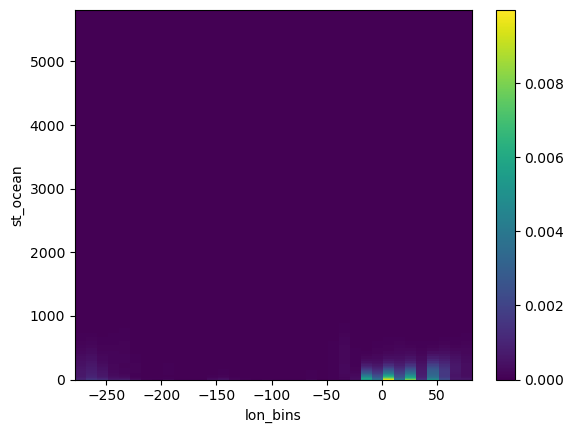

In [92]:
# visual check
EKE_clim.mean('dayofyear').plot()

### Correlations between CSHT from CDW and EKE

change code below!!!

In [93]:
#calculating monthly layerwise correlation
annual_layerwise_correlations_EKE = xr.corr(CSHT_CDW_annual,\
                                           EKE_annual,dim = 'time').compute()
annual_layerwise_correlations_r2s_EKE = (xr.corr(CSHT_CDW_annual,\
                                           EKE_annual,dim = 'time')**2).compute()



# daily correlations
daily_layerwise_correlations_EKE = xr.corr(CSHT_CDW_daily,\
                                           EKE_clim,dim = 'dayofyear').compute()
daily_layerwise_correlations_r2s_EKE = (xr.corr(CSHT_CDW_daily,\
                                           EKE_clim,dim = 'dayofyear')**2).compute()

In [104]:
import matplotlib.colors as mcolors

def custom_curl_cmap():
    # Get the original cmocean.cm.curl colormap
    #original_cmap = cmocean.curl
    original_cmap = experimental_cmap

    # Create a new colormap by adding a white band around zero
    # We define the number of colors for the colormap
    num_colors = 256

    # Create the original colormap and a new one for white band
    new_colors = original_cmap(np.linspace(0, 1, num_colors))
    # Define the position of the white band
    mid_point = num_colors // 2  # Middle index
    band_width = round(0.000001*256)  # Width of the white band -- middle 10% of range

    # Set the colors in the middle to white
    new_colors[mid_point - band_width//2 : mid_point + band_width//2] = [1, 1, 1, 1]  # RGBA for white
    
    # Create a new colormap from the modified color array
    custom_cmap = mcolors.ListedColormap(new_colors)

    return custom_cmap

In [106]:
N=11
base = plt.cm.get_cmap(cmocean.dense)
color_list = base(np.linspace(0, 1, N))
cmap_name = base.name + str(N)
discrete_dense = base.from_list(cmap_name, color_list, N)

Text(0.5, 1.0, '[a] Annual layerwise correlation ( i.e. EKE and CDW heat transport )')

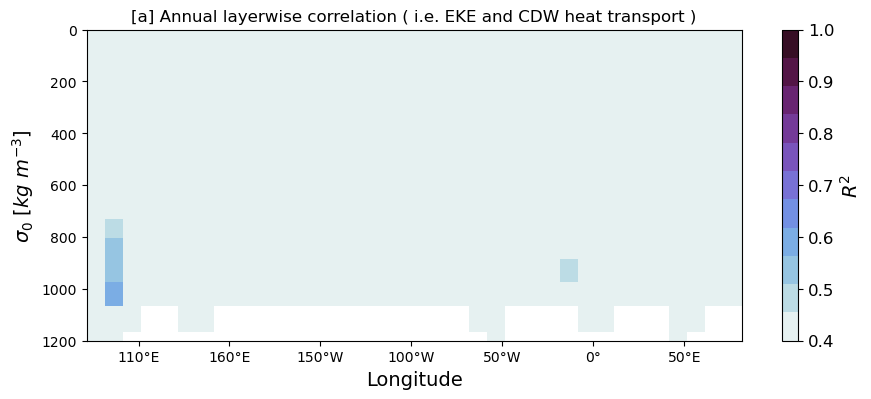

In [112]:
#conversor of vertical coordiantes
def warp(y):
    return 1.7**(y-23)  # exponential streching 1.5**(y-23)


fig = plt.figure(figsize=(22,14))
plt.subplots_adjust(
    left=0.1,    # the left side of the subplots of the figure
    right=0.9,   # the right side of the subplots of the figure
    bottom=0.1,  # the bottom of the subplots of the figure
    top=0.9,     # the top of the subplots of the figure
    wspace=0.15,  # the amount of width reserved for blank space between subplots
    hspace=0.3   # the amount of height reserved for white space between subplots
)

#monthly correlations
ax0 = fig.add_subplot(3,2,1)
plt.pcolormesh(annual_layerwise_correlations_r2s_EKE.lon_bins,annual_layerwise_correlations_r2s_EKE.st_ocean,\
               annual_layerwise_correlations_r2s_EKE.T,cmap=discrete_dense,vmin=0.4,vmax=1)

ax0.set_ylim(1200,0)
cbar0 = plt.colorbar()
cbar0.ax.tick_params(labelsize=12)
cbar0.set_label(label=r'$R^2$', size=14, weight='bold')
plt.ylabel(r'$\sigma_0$ [$kg\ m^{-3}$]',fontsize = 14)
ax0.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel(r'Longitude',fontsize = 14)
plt.title(r'[a] Annual layerwise correlation ( i.e. EKE and CDW heat transport )')




Text(0.5, 1.0, '[a] Daily layerwise correlation ( i.e. EKE and CDW heat transport )')

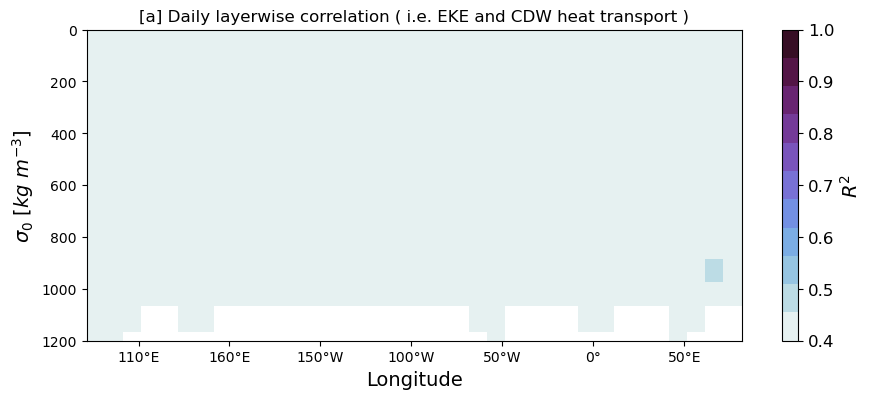

In [113]:
#conversor of vertical coordiantes
def warp(y):
    return 1.7**(y-23)  # exponential streching 1.5**(y-23)


fig = plt.figure(figsize=(22,14))
plt.subplots_adjust(
    left=0.1,    # the left side of the subplots of the figure
    right=0.9,   # the right side of the subplots of the figure
    bottom=0.1,  # the bottom of the subplots of the figure
    top=0.9,     # the top of the subplots of the figure
    wspace=0.15,  # the amount of width reserved for blank space between subplots
    hspace=0.3   # the amount of height reserved for white space between subplots
)

#monthly correlations
ax0 = fig.add_subplot(3,2,1)
plt.pcolormesh(daily_layerwise_correlations_r2s_EKE.lon_bins,daily_layerwise_correlations_r2s_EKE.st_ocean,\
               daily_layerwise_correlations_r2s_EKE.T,cmap=discrete_dense,vmin=0.4,vmax=1)

ax0.set_ylim(1200,0)
cbar0 = plt.colorbar()
cbar0.ax.tick_params(labelsize=12)
cbar0.set_label(label=r'$R^2$', size=14, weight='bold')
plt.ylabel(r'$\sigma_0$ [$kg\ m^{-3}$]',fontsize = 14)
ax0.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel(r'Longitude',fontsize = 14)
plt.title(r'[a] Daily layerwise correlation ( i.e. EKE and CDW heat transport )')

